In [2]:
from __future__ import print_function
import torch as t

In [3]:
#在创建tensor的时候指定requires_grad
a = t.randn(3,4, requires_grad=True)
# 或者
a = t.randn(3,4).requires_grad_()
# 或者
a = t.randn(3,4)
a.requires_grad = True
a

tensor([[ 0.0145, -1.5160, -2.4969, -0.9024],
        [ 1.8168, -0.3306,  2.4995, -0.7505],
        [ 1.0861,  0.1529, -1.3775,  1.6834]], requires_grad=True)

In [4]:
b = t.zeros(3,4).requires_grad_()
b

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)

In [5]:
# 也可写成c = a + b
c = a.add(b)
c

tensor([[ 0.0145, -1.5160, -2.4969, -0.9024],
        [ 1.8168, -0.3306,  2.4995, -0.7505],
        [ 1.0861,  0.1529, -1.3775,  1.6834]], grad_fn=<AddBackward0>)

In [6]:
d = c.sum()
d.backward() # 反向传播

In [7]:
d.requires_grad

True

In [8]:
a.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [9]:
b.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [10]:
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [11]:
c.grad is None

True

计算下面这个函数的导函数：
$$
y = x^2\bullet e^x
$$
它的导函数是：
$$
{dy \over dx} = 2x\bullet e^x + x^2 \bullet e^x
$$
来看看autograd的计算结果与手动求导计算结果的误差。

In [12]:
def f(x):
    y = x **2 * t.exp(x)
    return y

def gradf(x):
    dx = 2*x*t.exp(x) + x**2 *t.exp(x)
    return dx

In [13]:
x = t.randn (3,4, requires_grad=True)
y = f(x)
y

tensor([[1.2575e-01, 7.1989e-02, 4.0691e-02, 3.6559e-01],
        [5.2125e-01, 3.3537e-01, 6.0932e+00, 2.7329e-01],
        [5.3873e-01, 1.3379e-01, 2.8990e-01, 3.4718e-03]],
       grad_fn=<MulBackward0>)

In [14]:
y.backward(t.ones(y.size()))
x.grad

tensor([[-0.4427,  0.6765,  0.4830, -0.3702],
        [-0.1160, -0.3976, 15.5174, -0.4391],
        [-0.0393, -0.4473, -0.4300, -0.1108]])

In [15]:
dx = gradf(x)
dx

tensor([[-0.4427,  0.6765,  0.4830, -0.3702],
        [-0.1160, -0.3976, 15.5174, -0.4391],
        [-0.0393, -0.4473, -0.4300, -0.1108]], grad_fn=<AddBackward0>)

### 3.2.2 计算图

PyTorch中`autograd`的底层采用了计算图，计算图是一种特殊的有向无环图（DAG），用于记录算子与变量之间的关系。一般用矩形表示算子，椭圆形表示变量。如表达式$ \textbf {z = wx + b}$可分解为$\textbf{y = wx}$和$\textbf{z = y + b}$，其计算图如图3-3所示，图中`MUL`，`ADD`都是算子，$\textbf{w}$，$\textbf{x}$，$\textbf{b}$即变量。

![图3-3:computation graph](imgs/com_graph.svg)

如上有向无环图中，$\textbf{X}$和$\textbf{b}$是叶子节点（leaf node），这些节点通常由用户自己创建，不依赖于其他变量。$\textbf{z}$称为根节点，是计算图的最终目标。利用链式法则很容易求得各个叶子节点的梯度。
$${\partial z \over \partial b} = 1,\space {\partial z \over \partial y} = 1\\
{\partial y \over \partial w }= x,{\partial y \over \partial x}= w\\
{\partial z \over \partial x}= {\partial z \over \partial y} {\partial y \over \partial x}=1 * w\\
{\partial z \over \partial w}= {\partial z \over \partial y} {\partial y \over \partial w}=1 * x\\
$$
而有了计算图，上述链式求导即可利用计算图的反向传播自动完成，其过程如图3-4所示。

![图3-4：计算图的反向传播](imgs/com_graph_backward.svg)


在PyTorch实现中，autograd会随着用户的操作，记录生成当前variable的所有操作，并由此建立一个有向无环图。用户每进行一个操作，相应的计算图就会发生改变。更底层的实现中，图中记录了操作`Function`，每一个变量在图中的位置可通过其`grad_fn`属性在图中的位置推测得到。在反向传播过程中，autograd沿着这个图从当前变量（根节点$\textbf{z}$）溯源，可以利用链式求导法则计算所有叶子节点的梯度。每一个前向传播操作的函数都有与之对应的反向传播函数用来计算输入的各个variable的梯度，这些函数的函数名通常以`Backward`结尾。下面结合代码学习autograd的实现细节。

In [16]:
x = t.ones(1)
b = t.rand(1, requires_grad = True)
w = t.rand(1, requires_grad = True)
y = w * x # 等价于y=w.mul(x)
z = y + b # 等价于z=y.add(b)

In [17]:
x.requires_grad, b.requires_grad, w.requires_grad

(False, True, True)

In [18]:
y.requires_grad

True

In [19]:
x.is_leaf, w.is_leaf, b.is_leaf

(True, True, True)

In [20]:
y.is_leaf, z.is_leaf

(False, False)

In [21]:
# grad_fn可以查看这个variable的反向传播函数，
# z是add函数的输出，所以它的反向传播函数是AddBackward
z.grad_fn 

In [22]:
# next_functions保存grad_fn的输入，是一个tuple，tuple的元素也是Function
# 第一个是y，它是乘法(mul)的输出，所以对应的反向传播函数y.grad_fn是MulBackward
# 第二个是b，它是叶子节点，由用户创建，grad_fn为None，但是有
z.grad_fn.next_functions 

((<MulBackward0 at 0x7f3c83641278>, 0),
 (<AccumulateGrad at 0x7f3c836412b0>, 0))

In [23]:
z.grad_fn.next_functions [0][0] == y.grad_fn

True

In [24]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x7f3c836bef98>, 0), (None, 0))

In [25]:
# 使用retain_graph来保存buffer
z.backward(retain_graph=True)
w.grad

tensor([1.])

In [26]:
# 多次反向传播，梯度累加，这也就是w中AccumulateGrad标识的含义
z.backward()
w.grad

tensor([2.])

In [27]:
def abs(x):
    if x.data[0]>0: return x
    else: return -x
x = t.ones(1,requires_grad=True)
y = abs(x)
y.backward()
x.grad

tensor([1.])

In [29]:
def f(x):
    result = 1
    for ii in x:
        if ii.item()>0: result = ii*result
    return result
x = t.arange(-2.,4,requires_grad=True)
y = f(x) # y = x[3]*x[4]*x[5]
y.backward()
x.grad

tensor([0., 0., 0., 6., 3., 2.])

In [31]:
t.no_grad??

In [35]:
a = t.ones(3,4,requires_grad=True)
b = t.ones(3,4,requires_grad=True)
c = a * b

a.data


tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [36]:
a.data = t.tensor([[1., 2., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])# 还是一个tensor
a.data

tensor([[1., 2., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [37]:
a

tensor([[1., 2., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)

在反向传播过程中非叶子节点的导数计算完之后即被清空。若想查看这些变量的梯度，有两种方法：
- 使用autograd.grad函数
- 使用hook

`autograd.grad`和`hook`方法都是很强大的工具，更详细的用法参考官方api文档，这里举例说明基础的使用。推荐使用`hook`方法，但是在实际使用中应尽量避免修改grad的值。

In [39]:
# 第一种方法：使用grad获取中间变量的梯度
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
z = y.sum()
# z对y的梯度，隐式调用backward()
t.autograd.grad(z, y)

(tensor([1., 1., 1.]),)

In [40]:
t.autograd.grad(z, x)

(tensor([0.7799, 0.5988, 0.7307]),)

In [42]:
# 第二种方法：使用hook
# hook是一个函数，输入是梯度，不应该有返回值
def variable_hook(grad):
    print('y的梯度：',grad)

x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
# 注册hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

# 除非你每次都要用hook，否则用完之后记得移除hook
hook_handle.remove()

y的梯度： tensor([1., 1., 1.])


In [44]:
x = t.arange(0.,3, requires_grad=True)
y = x**2 + x*2
z = y.sum()
z.backward() # 从z开始反向传播
x.grad

tensor([2., 4., 6.])

In [46]:
x = t.arange(0.,3, requires_grad=True)
y = x**2 + x*2
z = y.sum()
y_gradient =  t.Tensor([1,1,1]) # dz/dy
y.backward(y_gradient) #从y开始反向传播
x.grad

tensor([2., 4., 6.])

在PyTorch中计算图的特点可总结如下：

- autograd根据用户对variable的操作构建其计算图。对变量的操作抽象为`Function`。
- 对于那些不是任何函数(Function)的输出，由用户创建的节点称为叶子节点，叶子节点的`grad_fn`为None。叶子节点中需要求导的variable，具有`AccumulateGrad`标识，因其梯度是累加的。
- variable默认是不需要求导的，即`requires_grad`属性默认为False，如果某一个节点requires_grad被设置为True，那么所有依赖它的节点`requires_grad`都为True。
- variable的`volatile`属性默认为False，如果某一个variable的`volatile`属性被设为True，那么所有依赖它的节点`volatile`属性都为True。volatile属性为True的节点不会求导，volatile的优先级比`requires_grad`高。
- 多次反向传播时，梯度是累加的。反向传播的中间缓存会被清空，为进行多次反向传播需指定`retain_graph`=True来保存这些缓存。
- 非叶子节点的梯度计算完之后即被清空，可以使用`autograd.grad`或`hook`技术获取非叶子节点的值。
- variable的grad与data形状一致，应避免直接修改variable.data，因为对data的直接操作无法利用autograd进行反向传播
- 反向传播函数`backward`的参数`grad_variables`可以看成链式求导的中间结果，如果是标量，可以省略，默认为1
- PyTorch采用动态图设计，可以很方便地查看中间层的输出，动态的设计计算图结构。

这些知识不懂大多数情况下也不会影响对pytorch的使用，但是掌握这些知识有助于更好的理解pytorch，并有效的避开很多陷阱

In [48]:
from torch.autograd import Function
class Sigmoid(Function):
                                                             
    @staticmethod
    def forward(ctx, x): 
        output = 1 / (1 + t.exp(-x))
        ctx.save_for_backward(output)
        return output
        
    @staticmethod
    def backward(ctx, grad_output): 
        output,  = ctx.saved_tensors
        grad_x = output * (1 - output) * grad_output
        return grad_x                            

In [50]:
# 采用数值逼近方式检验计算梯度的公式对不对
test_input = t.randn(3,4, dtype = t.double, requires_grad=True)
t.autograd.gradcheck(Sigmoid.apply, (test_input,), eps=1e-3)

True

In [59]:
def f_sigmoid(x):
    y = Sigmoid.apply(x)
    y.backward(t.ones(x.size()))
    
def f_naive(x):
    y =  1/(1 + t.exp(-x))
    y.backward(t.ones(x.size()))
    
def f_th(x):
    y = t.sigmoid(x)
    y.backward(t.ones(x.size()))
    
x=t.randn(100, 100, requires_grad=True)
%timeit -n 100 f_sigmoid(x)
%timeit -n 100 f_naive(x)
%timeit -n 100 f_th(x)

100 loops, best of 3: 267 µs per loop
100 loops, best of 3: 329 µs per loop
100 loops, best of 3: 180 µs per loop


显然`f_sigmoid`要比单纯利用`autograd`加减和乘方操作实现的函数快不少，因为f_sigmoid的backward优化了反向传播的过程。另外可以看出系统实现的built-in接口(t.sigmoid)更快。

### 3.2.4 小试牛刀: 用Variable实现线性回归
在上一节中讲解了利用tensor实现线性回归，在这一小节中，将讲解如何利用autograd/Variable实现线性回归。

In [60]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display 
import numpy as np

In [61]:
# 设置随机数种子，为了在不同人电脑上运行时下面的输出一致
t.manual_seed(1000) 

def get_fake_data(batch_size=8):
    ''' 产生随机数据：y = x*2 + 3，加上了一些噪声'''
    x = t.rand(batch_size,1) * 5
    y = x * 2 + 3 + t.randn(batch_size, 1)
    return x, y


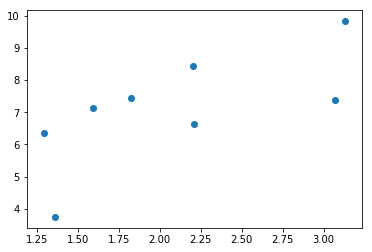

In [62]:
# 来看看产生x-y分布是什么样的
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

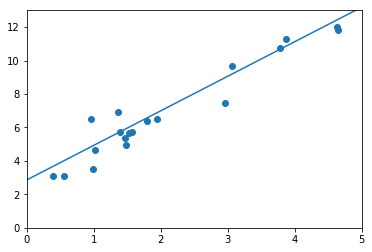

2.039273500442505 3.0045723915100098


In [64]:
# 随机初始化参数
w = t.rand(1,1, requires_grad=True)
b = t.zeros(1,1, requires_grad=True)
losses = np.zeros(500)

lr =0.005 # 学习率

for ii in range(500):
    x, y = get_fake_data(batch_size=32)
    
    # forward：计算loss
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()
    losses[ii] = loss.item()
    
    # backward：手动计算梯度
    loss.backward()
    
    # 更新参数
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if ii%50 ==0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0., 6).view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0,5)
        plt.ylim(0,13)   
        plt.show()
        plt.pause(0.5)
        
print(w.item(), b.item())

(5, 50)

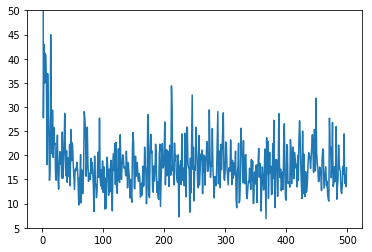

In [65]:
plt.plot(losses)
plt.ylim(5,50)
